# Gaia DR2 hypervelocity stars escaping the Milky Way

*From [this paper](http://adsabs.harvard.edu/doi/10.1093/mnras/sty2592). For Universe Update 18 Oct, 2018*

*Aaron Geller*

In [1]:
from astropy.table import Table
from astropy import units, constants
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord

import numpy as np
import matplotlib.pyplot as plt

from galpy.potential import MWPotential2014
from galpy.orbit import Orbit

%matplotlib notebook

*I scraped this out of the paper/1804.10607 file that I downloaded from the arXiv, and edited the file to remove things astropy doesn't understand.*

*The first 7 are "Galactic" ; the next 13 are "Extragalactic".*

In [2]:
tab = Table.read('table2.tex')
tab

\Gaia DR2 ID,RA,Dec.,$\varpi$,$E\varpi$,$\mu_{\alpha*}$,$E\mu_{\alpha*}$,$\mu_\delta$,$E\mu_\delta$,$v_\mathrm{rad}$,$Ev_\mathrm{rad}$,G,d,Ed+,Ed-,$r_\mathrm{GC}$,$v_\mathrm{GC}$,$P_\mathrm{MW}$,$P_\mathrm{ub}$
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str21,str17,float64,float64
5932173855446728064,244.1181,-54.44045,0.454,0.029,-2.676,0.043,-4.991,0.034,-614.286,2.492,13.81,2197,162,-120,6397^{+92}_{-123},747^{+2}_{-3},1.0,1.0
1383279090527227264,240.33735,41.16677,0.118,0.016,-25.759,0.025,-9.745,0.04,-180.902,2.421,13.01,8491,1376,-951,10064^{+908}_{-561},921^{+179}_{-124},1.0,1.0
6456587609813249536,317.36089,-57.9124,0.099,0.019,13.002,0.029,-18.263,0.03,-15.851,2.833,13.01,10021,2023,-1480,7222^{+1350}_{-761},875^{+212}_{-155},0.98,0.99
5935868592404029184,253.90291,-53.29868,0.074,0.021,5.47,0.032,6.358,0.026,308.412,1.212,13.08,12150,2919,-1909,5985^{+2516}_{-1380},747^{+110}_{-73},0.83,0.98
5831614858352694400,247.45238,-59.96738,-0.008,0.025,4.405,0.032,1.532,0.03,258.295,1.245,13.37,20196,6006,-4394,14113^{+5781}_{-4061},664^{+130}_{-93},0.94,0.92
5239334504523094784,158.89457,-65.46548,0.038,0.013,-6.77,0.025,2.544,0.022,22.464,1.891,13.39,19353,4247,-2940,18351^{+3923}_{-2617},609^{+140}_{-94},0.77,0.88
4395399303719163904,258.75009,8.73145,0.073,0.019,-9.911,0.029,4.848,0.029,24.364,1.484,13.19,12848,2766,-2262,8194^{+2309}_{-1620},671^{+136}_{-106},1.0,0.84
1396963577886583296,237.73164,44.4357,-0.017,0.014,-1.649,0.023,-4.966,0.029,-412.464,1.002,13.24,31374,6332,-5185,30720^{+6150}_{-4970},693^{+145}_{-113},0.0,0.98
5593107043671135744,113.26944,-31.3792,-0.1,0.017,-1.582,0.03,2.113,0.028,104.437,1.511,13.39,37681,8295,-6444,41753^{+8183}_{-6322},567^{+100}_{-76},0.0,0.97


In [3]:
print(tab.columns)

<TableColumns names=('\Gaia DR2 ID','RA','Dec.','$\varpi$','$E\varpi$','$\mu_{\alpha*}$','$E\mu_{\alpha*}$','$\mu_\delta$','$E\mu_\delta$','$v_\mathrm{rad}$','$Ev_\mathrm{rad}$','G','d','Ed+','Ed-','$r_\mathrm{GC}$','$v_\mathrm{GC}$','$P_\mathrm{MW}$','$P_\mathrm{ub}$')>


In [4]:
#Note: I *think* the pm in RA is already multiplied by cosine dec...
cd = SkyCoord(tab['RA']*units.deg, tab['Dec.']*units.deg, tab['d']*units.pc, \
                pm_ra_cosdec=tab[r'$\mu_{\alpha*}$']*units.mas/units.yr, \
                pm_dec=tab[r'$\mu_\delta$']*units.mas/units.yr, \
                radial_velocity=tab[r'$v_\mathrm{rad}$']*units.km/units.s)
print(cd.cartesian)
print(cd.velocity)

[(  -557.72223946,  -1149.50765284,  -1787.28482891),
 ( -3163.3505497 ,  -5554.35391932,   5589.22596061),
 (  3916.01093274,  -3605.89305986,  -8490.16104768),
 ( -2013.32995763,  -6976.67515581,  -9741.40679019),
 ( -3875.90746455,  -9335.31554361, -17484.49716255),
 ( -7497.09616972,   2893.70498006, -17605.6419795 ),
 ( -2477.45210017, -12455.09503159,   1950.36992526),
 (-11960.20114359, -18942.31874919,  21965.20031797),
 (-12708.84788448,  29552.99390288, -19620.48668677),
 (-14263.02330623,  19893.0388551 , -15666.3019017 ),
 (-10499.88921119,   7424.2103425 , -22758.14200112),
 ( -1832.70798871,  -4747.67394621,  -1317.88562804),
 (-10123.63438955,   8451.89389474, -25293.3418381 ),
 (  6220.31861323,  -9110.82523818,  -7005.22118347),
 (  2341.94893362, -12927.14109138,  -6489.58453183),
 (  5274.68516035,  -1059.09458924,  -8755.12370616),
 (  -309.16769335, -12448.94246992,   6937.81462119),
 ( -3845.92502323, -10554.66861829, -21041.04881117),
 ( 10003.71250736,  -2867.31

## Integrate these orbits in the MW potential

*Using [galpy](https://galpy.readthedocs.io/en/v1.4.0/), and following [this tutorial](https://galpy.readthedocs.io/en/v1.4.0/getting_started.html#orbit-integration).*

*First I will test to make sure it works, with a star that should be bound.*

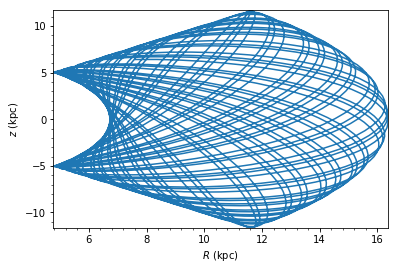

In [5]:
i=1

c = SkyCoord(tab['RA'][i]*units.deg, tab['Dec.'][i]*units.deg, tab['d'][i]*units.pc, \
                pm_ra_cosdec=tab[r'$\mu_{\alpha*}$'][i]*units.mas/units.yr/1000., \
                pm_dec=tab[r'$\mu_\delta$'][i]*units.mas/units.yr/1000., \
                radial_velocity=tab[r'$v_\mathrm{rad}$'][i]*units.km/units.s/1000.)

o=Orbit(c)
ts=np.linspace(0.,10.,2000)*units.Gyr
o.integrate(ts,MWPotential2014)
o.plot()


*Now with the actual data. Trying to reproduce Figure 9 in [their paper](http://adsabs.harvard.edu/doi/10.1093/mnras/sty2592).*

(-15, 30)

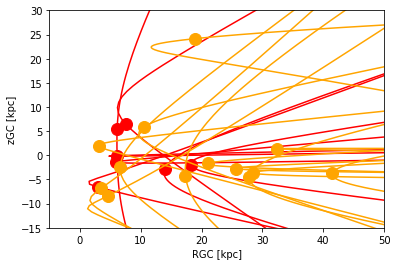

In [19]:
f,ax = plt.subplots()

#ts=np.linspace(-20.,20,2000)*units.Myr
ts=np.linspace(0,1,500)*units.Gyr
for i in range(len(cd)):
    o=Orbit(cd[i])
    ob=o.flip()
    o.integrate(ts,MWPotential2014)
    ob.integrate(ts,MWPotential2014)
    if (i < 7):
        co='red'
    else:
        co='orange'
    ax.plot(o.R([0]*units.Gyr), o.z([0]*units.Gyr),'o', color=co, markersize=12)
    ax.plot(o.R(ts), o.z(ts), color=co)
    ax.plot(ob.R(ts), ob.z(ts), color=co)

ax.set_xlabel('RGC [kpc]')
ax.set_ylabel('zGC [kpc]')
ax.set_xlim(-5, 50)
ax.set_ylim(-15, 30)


*Write to a raw file.*

In [21]:
import csv

In [24]:
def row(o, t1, t2, co, back=False):
    x1 = o.x(t1)
    y1 = o.y(t1)
    z1 = o.z(t1)
    x2 = o.x(t2)
    y2 = o.y(t2)
    z2 = o.z(t2)
    t1w = t1.to(units.Gyr).value
    t2w = t2.to(units.Gyr).value
    if (back):
        t1w*=-1.
        t2w*=-1.
    csvwriter.writerow([x1,y1,z1, x2,y2,z2, t1w,t2w,co])

csvfile = open("GaiaHVstars.raw", 'wt')
csvwriter = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
for i in range(len(cd)):
    o=Orbit(cd[i])
    ob=o.flip()
    o.integrate(ts,MWPotential2014)
    ob.integrate(ts,MWPotential2014)

    if (i < 7):
        co=1
    else:
        co=0
    for j in range(len(ts)-1)[::-1]:
        row(ob, ts[j], ts[j+1], co, back=True)
    for j in range(len(ts)-1):
        row(o, ts[j], ts[j+1], co)

csvfile.close()